In [38]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import skimage as ski
import sns
import tensorflow as tf
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


## Data Handling

In [39]:
cifar = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = cifar
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship','truck']

In [40]:
# Taking a number of data points from each class
def get_N_from_each_class(N, percentage_of_testing_data, x_train, y_train, x_test, y_test):
    # Generating indices for the data points we are going to take from the data (both test and train)
    selected_indices = []
    for class_label in range(10):
        # For every possible index, take the index iff the point belongs to this class 
        class_indices = [i for i in range(len(y_train)) if y_train[i][0] == class_label]
        selected_indices.append(class_indices[:N])

    # Picking the data based on the indices
    x_train = x_train[selected_indices]
    y_train = y_train[selected_indices]
    # Reshaping the data to flatten it to all classes together (to get it back to original form)
    x_train = x_train.reshape(-1, 32, 32, 3)
    y_train = y_train.reshape(-1, 1)

    # Doing the same with the test data
    selected_indices = []
    for class_label in range(10):
        class_indices = [i for i in range(len(y_test)) if y_test[i][0] == class_label]
        selected_indices.append(class_indices[:int(N * percentage_of_testing_data)])

    x_test = x_test[selected_indices]
    y_test = y_test[selected_indices]
    x_test = x_test.reshape(-1, 32, 32, 3)
    y_test = y_test.reshape(-1, 1)

    # Randomizing data, just in case
    # np.random.shuffle(x_train)
    # np.random.shuffle(y_train)
    # np.random.shuffle(x_test)
    # np.random.shuffle(y_test)

    indices = np.random.permutation(len(x_train))
    x_train = x_train[indices]
    y_train = y_train[indices]

    indices = np.random.permutation(len(x_test))
    x_test = x_test[indices]
    y_test = y_test[indices]

    y_train = y_train.ravel()
    y_test = y_test.ravel()

    return (x_train, y_train), (x_test, y_test)


n_samples_from_each_class = 2000
(x_train, y_train), (x_test, y_test) = get_N_from_each_class(n_samples_from_each_class, 0.3, x_train, y_train, x_test,
                                                             y_test)

In [41]:
# extrating the features from the images
# method used: Central Moments

def extract_image_features(image, C=3):
    '''
    Extracts the features from the image using the central moments method of order C
    It turns the image to grayscale, then calculates the central moments of order C
    
    Parameters:
    image: the image to be processed
    C: the moments order

    Returns:
    features: a vector of the features extracted from the image
    '''

    # turning the image to grayscale
    image = ski.color.rgb2gray(image)

    # calculating the central moments
    cal_moments = ski.measure.moments_central(image, order=C)

    # create an np array that contains zeroes 
    features = np.zeros(shape=int((C + 1) * (C + 2) / 2))

    # turn the 2D array to 1D by putting only the needed values based on this equation 
    # p + q <= C 
    # if C = 3 the needed numbers are : 00 01 10 11 20 02 21 12 03 30 , size = 10 s
    current = 0;
    for i in range(C + 1):
        for j in range(C + 1):
            if (i + j <= C):
                features[current] = cal_moments[i][j]
                current = current + 1

    return features



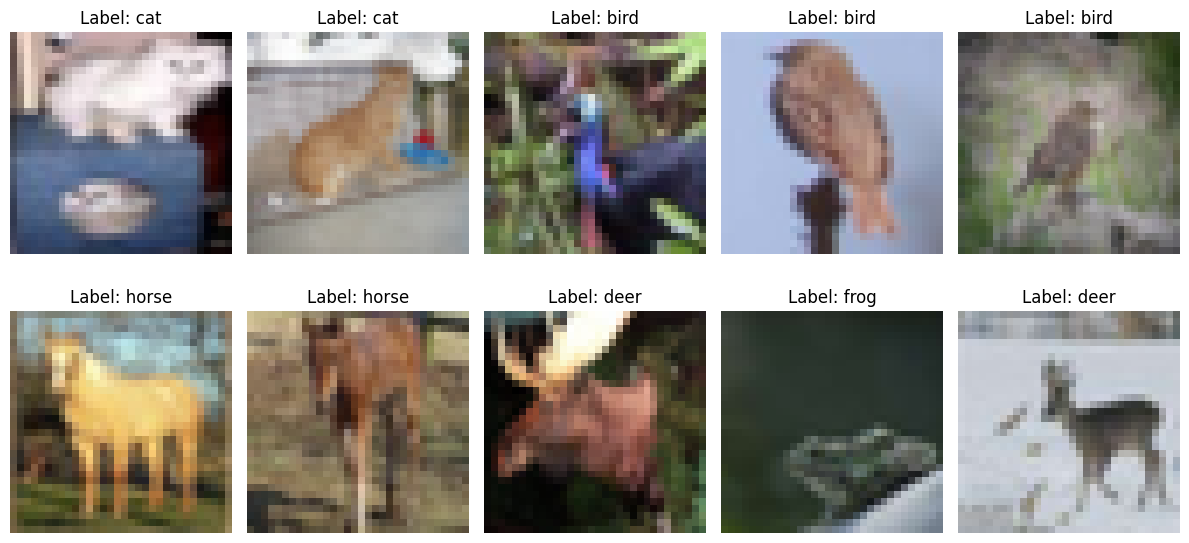

In [42]:
#Display a sample of images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_train[i])
    ax.axis('off')
    ax.set_title(f'Label: {labels[y_train[i]]}')

plt.tight_layout()
plt.show()


In [43]:
from sklearn.preprocessing import StandardScaler

C_order = 5
# Extracting the images features
Training_features = np.array([extract_image_features(x_train[i], C_order) for i in range(len(x_train))])
Testing_features = np.array([extract_image_features(x_test[i], C_order) for i in range(len(x_test))])

#standardize the data
scaler = StandardScaler().fit(Training_features)
standardized_training_features = scaler.transform(Training_features)
standardized_test_features = scaler.transform(Testing_features)


##### KNN 

( An Example for KNN Classification )

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

* The parameter we are going to experiment with the value of K (number of neighbors)
* The same thing as in SVM we are going to use `make_pipeline` and `StandardScaler` 

In [44]:
k_neighbours = 11

# Making the model
knn_model = KNeighborsClassifier(k_neighbours)

# Tuning the model
param_grid = {'n_neighbors': np.arange(1, 100)}
knn_grid = GridSearchCV(knn_model, param_grid)
knn_grid.fit(Training_features, y_train)
print(f'Best parameters: {knn_grid.best_params_}')


Best parameters: {'n_neighbors': 68}


In [45]:

# Using the best parameters to make the model
k_neighbours = knn_grid.best_params_['n_neighbors']
knn_model = KNeighborsClassifier(k_neighbours)
knn_model.fit(Training_features, y_train)

# Predicting the test data
y_pred = knn_model.predict(Testing_features)


print(f'R2: {r2_score(y_pred, y_test)}')
print(f'Test accuracy: {accuracy_score(y_pred, y_test)}')
print(f'Test precision: {precision_score(y_pred, y_test, average="macro")}')
print(f'Test recall: {recall_score(y_pred, y_test, average="macro")}')
print(f'Test f1 score: {f1_score(y_pred, y_test, average="macro")}')




R2: -0.84295165767815
Test accuracy: 0.18666666666666668
Test precision: 0.18666666666666668
Test recall: 0.17767232767232768
Test f1 score: 0.1715794435916387


Correct Examples: 3
Incorrect Examples: 7


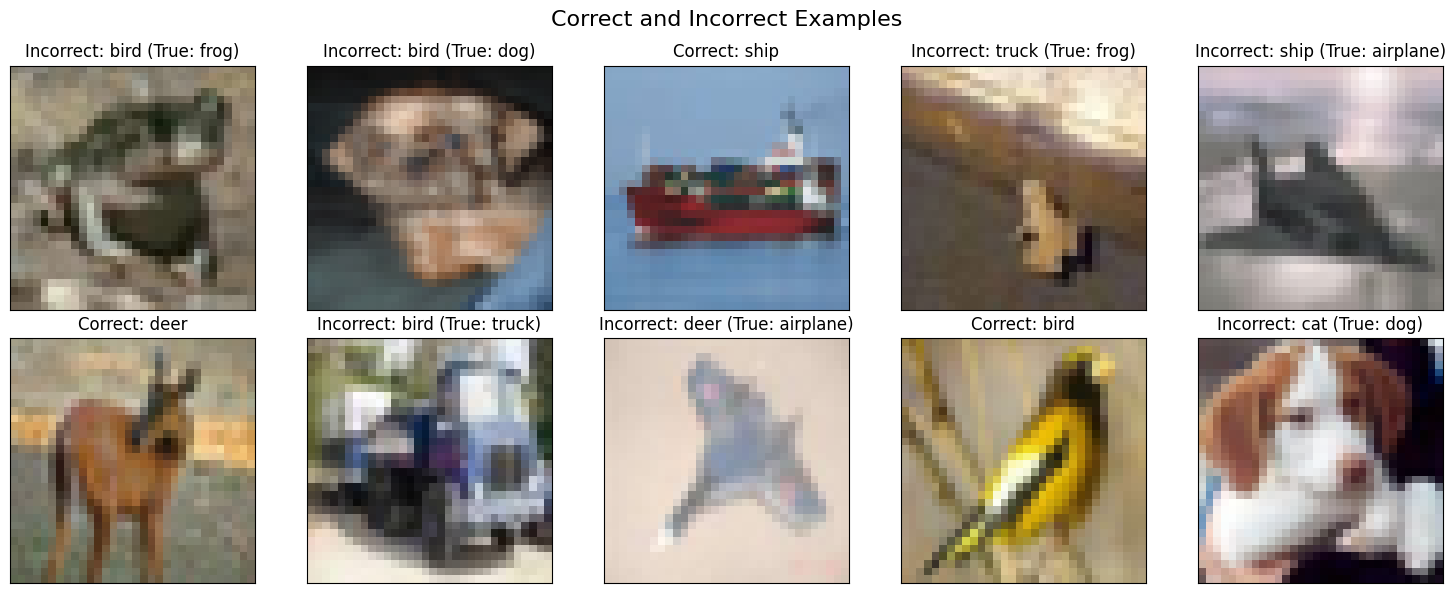

In [46]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Correct and Incorrect Examples', fontsize=16)

# Initialize counters for correct and incorrect examples
correct_count = 0
incorrect_count = 0

# Iterate over the predicted labels and compare with true labels
for i, ax in enumerate(axes.flat):
    # Get the predicted and true labels for the current example
    predicted_label = y_pred[i]
    true_label = y_test[i]

    # Check if the prediction is correct
    if predicted_label == true_label:
        # Plot the correct example
        ax.imshow(x_test[i])
        ax.set_title(f'Correct: {labels[predicted_label]}')
        correct_count += 1
    else:
        # Plot the incorrect example
        ax.imshow(x_test[i])
        ax.set_title(f'Incorrect: {labels[predicted_label]} (True: {labels[true_label]})')
        incorrect_count += 1

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust spacing between subplots
plt.tight_layout()

# Print the count of correct and incorrect examples
print(f'Correct Examples: {correct_count}')
print(f'Incorrect Examples: {incorrect_count}')
